In [ ]:
# Importar bibliotecas necesarias
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.utils import class_weight
from sklearn.preprocessing import label_binarize

import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2, ResNet50, EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Concatenate, Input, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model

In [ ]:
# Definir parámetros de la red y del entrenamiento
EPOCHS = 100
IMAGE_SIZE = (256, 256)
INPUT_SHAPE = (256, 256, 3)
SEED = 123
BATCH_SIZE = 32
BUFFER_SIZE = 1000
LEARNING_RATE = 1e-4

In [ ]:
# Montar Google Drive si estás utilizando Colab
from google.colab import drive
drive.mount('/content/drive')

# Directorio de imágenes original
images_dir = '/content/drive/My Drive/arcgis-survey-images-new-last'

# **Definir el directorio base para los conjuntos de datos separados**
base_separated_dir = '/content/drive/My Drive/dataset_separado'

# Subdirectorios para train, validation y test
train_dir = os.path.join(base_separated_dir, 'train')
val_dir = os.path.join(base_separated_dir, 'validation')
test_dir = os.path.join(base_separated_dir, 'test')

Mounted at /content/drive


In [ ]:
# Obtener las clases y asignar etiquetas numéricas
class_names = sorted([d for d in os.listdir(images_dir) if os.path.isdir(os.path.join(images_dir, d))])
class_to_label = {class_name: idx for idx, class_name in enumerate(class_names)}

print(f"Clases encontradas: {class_names}")

Clases encontradas: ['Chinche salivosa', 'Clororis', 'Hoja sana', 'Roya naranja', 'Roya purpura']


In [ ]:
# Crear listas para almacenar rutas y etiquetas
image_paths = []
labels = []

for class_name in class_names:
    class_dir = os.path.join(images_dir, class_name)
    for fname in os.listdir(class_dir):
        if fname.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
            image_paths.append(os.path.join(class_dir, fname))
            labels.append(class_to_label[class_name])

In [ ]:
# Crear el DataFrame
data_df = pd.DataFrame({
    'filepath': image_paths,
    'label': labels
})

print(f"Distribución original de clases:\n{data_df['label'].value_counts()}")

Distribución original de clases:
label
3    1161
4     907
2     846
0     825
1     569
Name: count, dtype: int64


In [ ]:
# # **Definir función para crear carpetas para cada conjunto y clase**
# def crear_carpetas(base, clases):
#     if not os.path.exists(base):
#         os.makedirs(base)
#     for clase in clases:
#         clase_dir = os.path.join(base, clase)
#         if not os.path.exists(clase_dir):
#             os.makedirs(clase_dir)

# # **Crear carpetas para train, validation y test**
# crear_carpetas(train_dir, class_names)
# crear_carpetas(val_dir, class_names)
# crear_carpetas(test_dir, class_names)

In [ ]:
# # **Función para copiar imágenes a la carpeta de destino correspondiente**
# import shutil

# def copiar_imagenes(df, origen_columna, destino_dir):
#     for index, row in df.iterrows():
#         origen = row[origen_columna]
#         etiqueta = row['label']
#         nombre_archivo = os.path.basename(origen)
#         clase = class_names[etiqueta]
#         destino = os.path.join(destino_dir, clase, nombre_archivo)

#         # Verificar si el archivo de origen existe
#         if not os.path.exists(origen):
#             print(f"Archivo no encontrado: {origen}")
#             continue

#         # Copiar la imagen
#         shutil.copy2(origen, destino)

In [ ]:
# Primero, dividir en conjunto de entrenamiento+validación y prueba
train_val_df, test_df = train_test_split(
    data_df,
    test_size=0.2,
    stratify=data_df['label'],
    random_state=SEED
)

# Luego, dividir el conjunto de entrenamiento+validación en entrenamiento y validación
train_df, val_df = train_test_split(
    train_val_df,
    test_size=0.25,  # 0.25 x 0.8 = 0.2, es decir, el 20% del total
    stratify=train_val_df['label'],
    random_state=SEED
)

print(f"Distribución de clases en entrenamiento:\n{train_df['label'].value_counts()}")
print(f"Distribución de clases en validación:\n{val_df['label'].value_counts()}")
print(f"Distribución de clases en prueba:\n{test_df['label'].value_counts()}")


Distribución de clases en entrenamiento:
label
3    696
4    544
2    508
0    495
1    341
Name: count, dtype: int64
Distribución de clases en validación:
label
3    233
4    181
2    169
0    165
1    114
Name: count, dtype: int64
Distribución de clases en prueba:
label
3    232
4    182
2    169
0    165
1    114
Name: count, dtype: int64


In [ ]:
# # **Copiar imágenes a las carpetas correspondientes**
# copiar_imagenes(train_df, 'filepath', train_dir)
# copiar_imagenes(val_df, 'filepath', val_dir)
# copiar_imagenes(test_df, 'filepath', test_dir)

In [ ]:
# Calcular los pesos de clase utilizando el conjunto de entrenamiento
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_df['label']),
    y=train_df['label']
)
class_weights = dict(enumerate(class_weights))
print(f"Pesos de clase: {class_weights}")

Pesos de clase: {0: 1.044040404040404, 1: 1.515542521994135, 2: 1.0173228346456693, 3: 0.7425287356321839, 4: 0.95}


In [ ]:
# Definir data augmentation mejorada
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal_and_vertical'),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomContrast(0.2),
    tf.keras.layers.Lambda(lambda x: tf.image.adjust_brightness(x, delta=0.2))
])

In [ ]:
# Función para cargar y preprocesar las imágenes
def load_and_preprocess_image(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_image(image, channels=3, expand_animations=False)
    image = tf.image.resize(image, IMAGE_SIZE)
    image = tf.cast(image, tf.float32)
    image = data_augmentation(image)
    # Preprocesamiento específico para MobileNetV2
    image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
    return image, label


In [ ]:
# Función para extraer rutas y etiquetas del DataFrame
def path_to_image_label(df):
    return df['filepath'].values, df['label'].values

In [ ]:
# Extraer rutas y etiquetas
train_paths, train_labels = path_to_image_label(train_df)
val_paths, val_labels = path_to_image_label(val_df)
test_paths, test_labels = path_to_image_label(test_df)  # **Agregado para el conjunto de prueba**

# Crear TensorFlow Datasets
train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
val_ds = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))
test_ds = tf.data.Dataset.from_tensor_slices((test_paths, test_labels))  # **Agregado para el conjunto de prueba**

# Aplicar la función de preprocesamiento
train_ds = train_ds.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

val_ds = val_ds.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

test_ds = test_ds.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)  # **Agregado para el conjunto de prueba**
test_ds = test_ds.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
# Definir las entradas del modelo
inputs = Input(shape=INPUT_SHAPE)

In [ ]:
# Modelos base con fine-tuning
# Modelo base 1: MobileNetV2
base_model_mobilenet = MobileNetV2(input_shape=INPUT_SHAPE, include_top=False, weights='imagenet')
base_model_mobilenet.trainable = True  # Permitir fine-tuning
# Descongelar las últimas 20 capas
for layer in base_model_mobilenet.layers:
    layer.trainable = True

x1 = base_model_mobilenet(inputs)
x1 = GlobalAveragePooling2D()(x1)
x1 = BatchNormalization()(x1)


<ipython-input-54-6223c9f7cf43>:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model_mobilenet = MobileNetV2(input_shape=INPUT_SHAPE, include_top=False, weights='imagenet')


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
# Modelo base 2: ResNet50
base_model_resnet = ResNet50(input_shape=INPUT_SHAPE, include_top=False, weights='imagenet')
base_model_resnet.trainable = True
for layer in base_model_resnet.layers:
    layer.trainable = True

x2 = base_model_resnet(inputs)
x2 = GlobalAveragePooling2D()(x2)
x2 = BatchNormalization()(x2)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [ ]:
# Modelo base 3: EfficientNetB0
base_model_efficientnet = EfficientNetB0(input_shape=INPUT_SHAPE, include_top=False, weights='imagenet')
base_model_efficientnet.trainable = True
for layer in base_model_efficientnet.layers:
    layer.trainable = True

x3 = base_model_efficientnet(inputs)
x3 = GlobalAveragePooling2D()(x3)
x3 = BatchNormalization()(x3)


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
# Concatenar las salidas de los tres modelos
combined = Concatenate()([x1, x2, x3])

In [ ]:
# Modificar el bloque de capas densas adicionales en el ensamble
x = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01))(combined)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

x = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

x = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

# Salida final (no se cambia)
outputs = Dense(len(class_names), activation='softmax')(x)


In [ ]:
# Crear el modelo final
ensemble_model = Model(inputs=inputs, outputs=outputs)

In [ ]:
# Compilar el modelo con un learning rate reducido
ensemble_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
                       loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                       metrics=['accuracy'])

In [ ]:
# Resumen del modelo
ensemble_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ mobilenetv2_1.00_224      │ (None, 8, 8, 1280)     │      2,257,984 │ input_layer_3[0][0]    │
│ (Functional)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ resnet50 (Functional)     │ (None, 8, 8, 2048)     │     23,587,712 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ efficientnetb0            │ (None, 8, 8, 1280)     │      4,049,571 │ input_layer_3[0][0]    │
│ (Functional)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d  │ (None, 1280)           │              0 │ mobilenetv2_1.00_224[… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 2048)           │              0 │ resnet50[0][0]         │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 1280)           │              0 │ efficientnetb0[0][0]   │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 1280)           │          5,120 │ global_average_poolin… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 2048)           │          8,192 │ global_average_poolin… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 1280)           │          5,120 │ global_average_poolin… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 4608)           │              0 │ batch_normalization[0… │
│                           │                        │                │ batch_normalization_1… │
│                           │                        │                │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 512)            │      2,359,808 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 512)            │          2,048 │ dense[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)    

 Total params: 32,441,960 (123.76 MB)

 Trainable params: 32,301,697 (123.22 MB)

 Non-trainable params: 140,263 (547.91 KB)

In [ ]:
# Definir callbacks
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True)

# Modificar el callback de ModelCheckpoint para guardar solo los pesos en formato .weights.h5
checkpoint_dir = 'best_ensemble_model_weights.weights.h5'
model_checkpoint = ModelCheckpoint(filepath=checkpoint_dir,
                                   monitor='val_loss',
                                   save_best_only=True,
                                   save_weights_only=True,  # Guardar solo los pesos
                                   verbose=1)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.5,
                              patience=5,
                              min_lr=1e-6,
                              verbose=1)

tensorboard_log_dir = "/content/drive/My Drive/logs/fit/" + pd.Timestamp.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=tensorboard_log_dir, histogram_freq=1)

In [ ]:
# Entrenamiento del modelo de ensamble con pesos de clase
history = ensemble_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    class_weight=class_weights,
    callbacks=[early_stop, model_checkpoint, reduce_lr, tensorboard_callback]
)

Epoch 1/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2859 - loss: 16.7012   
Epoch 1: val_loss improved from inf to 15.81524, saving model to best_ensemble_model_weights.weights.h5
81/81 ━━━━━━━━━━━━━━━━━━━━ 385s 2s/step - accuracy: 0.2866 - loss: 16.6968 - val_accuracy: 0.2819 - val_loss: 15.8152 - learning_rate: 1.0000e-04
Epoch 2/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 648ms/step - accuracy: 0.5170 - loss: 15.5629
Epoch 2: val_loss improved from 15.81524 to 15.61990, saving model to best_ensemble_model_weights.weights.h5
81/81 ━━━━━━━━━━━━━━━━━━━━ 75s 867ms/step - accuracy: 0.5174 - loss: 15.5608 - val_accuracy: 0.4211 - val_loss: 15.6199 - learning_rate: 1.0000e-04
Epoch 3/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 656ms/step - accuracy: 0.6330 - loss: 14.9966
Epoch 3: val_loss did not improve from 15.61990
81/81 ━━━━━━━━━━━━━━━━━━━━ 73s 846ms/step - accuracy: 0.6332 - loss: 14.9950 - val_accuracy: 0.3202 - val_loss: 15.7075 - learning_rate: 1.0000e-04
Epoch 4/100
81/81 ━━━━━━━━━━━━━━━

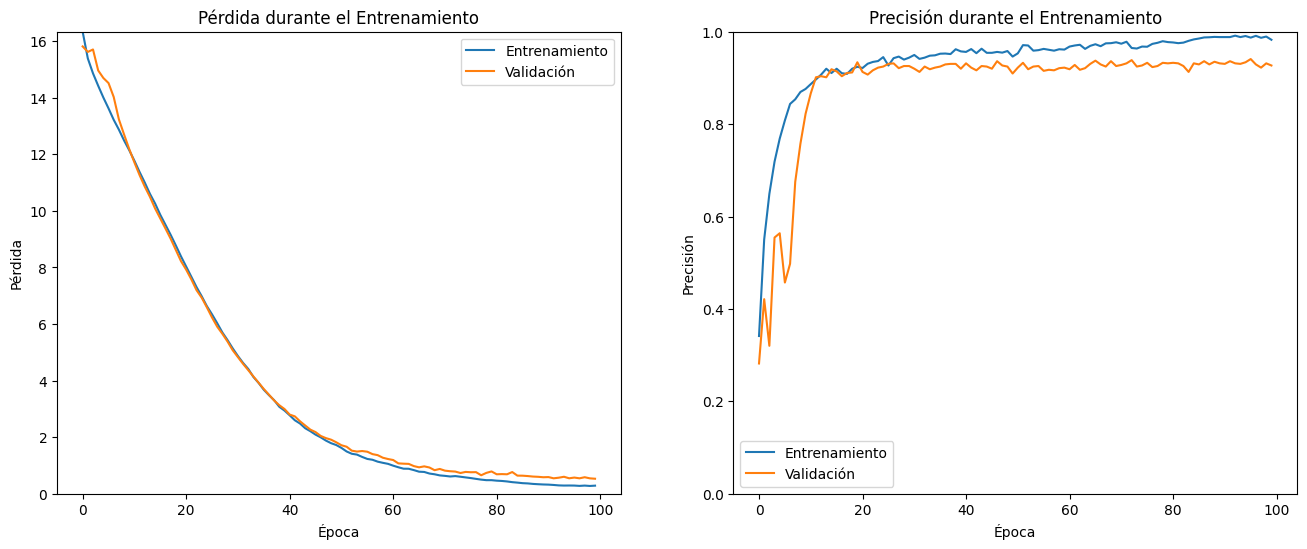

In [ ]:
# Gráfica de la pérdida y precisión
metrics = history.history
plt.figure(figsize=(16, 6))

# Pérdida
plt.subplot(1, 2, 1)
plt.plot(history.epoch, metrics['loss'], label='Entrenamiento')
plt.plot(history.epoch, metrics['val_loss'], label='Validación')
plt.legend()
plt.ylim([0, max(metrics['loss'] + metrics['val_loss'])])
plt.ylabel('Pérdida')
plt.xlabel('Época')
plt.title('Pérdida durante el Entrenamiento')

# Precisión
plt.subplot(1, 2, 2)
plt.plot(history.epoch, metrics['accuracy'], label='Entrenamiento')
plt.plot(history.epoch, metrics['val_accuracy'], label='Validación')
plt.legend()
plt.ylim([0, 1])
plt.ylabel('Precisión')
plt.xlabel('Época')
plt.title('Precisión durante el Entrenamiento')

plt.show()

In [ ]:
# Guardar en formato HDF5
ensemble_model.save('ensemble_model.h5', save_format='h5')


In [ ]:
# Cargar desde el archivo HDF5
ensemble_model_loaded = tf.keras.models.load_model('ensemble_model (2).h5')

# Evaluar el modelo cargado
val_results_loaded = ensemble_model_loaded.evaluate(val_ds, return_dict=True)
print("Resultados de evaluación en el conjunto de validación (modelo cargado desde HDF5):")
for metric, value in val_results_loaded.items():
    print(f"{metric}: {value:.4f}")


27/27 ━━━━━━━━━━━━━━━━━━━━ 111s 3s/step - accuracy: 0.9347 - loss: 0.5268
Resultados de evaluación en el conjunto de validación (modelo cargado desde HDF5):
accuracy: 0.9350
loss: 0.5524


In [ ]:
# Obtener predicciones en el conjunto de validación
y_val_pred_probs = ensemble_model_loaded.predict(val_ds)
y_val_pred = np.argmax(y_val_pred_probs, axis=1)

27/27 ━━━━━━━━━━━━━━━━━━━━ 27s 632ms/step


In [ ]:
# Obtener etiquetas verdaderas del conjunto de validación
y_val_true = np.concatenate([y for x, y in val_ds], axis=0)

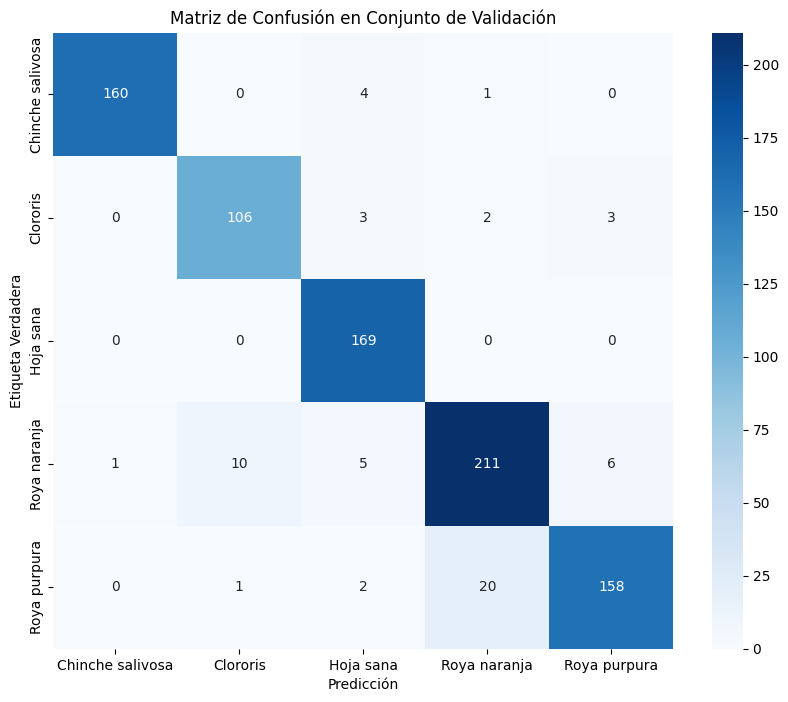

In [ ]:
# Calcular la matriz de confusión en validación
conf_matrix_val = tf.math.confusion_matrix(y_val_true, y_val_pred).numpy()

# Visualizar la matriz de confusión en validación
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_val, xticklabels=class_names, yticklabels=class_names, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicción')
plt.ylabel('Etiqueta Verdadera')
plt.title('Matriz de Confusión en Conjunto de Validación')
plt.show()


In [ ]:
# Reporte de clasificación en validación
print("Reporte de clasificación en Conjunto de Validación:")
print(classification_report(y_val_true, y_val_pred, target_names=class_names))

Reporte de clasificación en Conjunto de Validación:
                  precision    recall  f1-score   support

Chinche salivosa       0.99      0.97      0.98       165
        Clororis       0.91      0.93      0.92       114
       Hoja sana       0.92      1.00      0.96       169
    Roya naranja       0.90      0.91      0.90       233
    Roya purpura       0.95      0.87      0.91       181

        accuracy                           0.93       862
       macro avg       0.93      0.94      0.93       862
    weighted avg       0.93      0.93      0.93       862



In [ ]:
# **Evaluar el modelo en el conjunto de prueba**
test_results = ensemble_model_loaded.evaluate(test_ds, return_dict=True)
print("Resultados de evaluación en el conjunto de prueba:")
for metric, value in test_results.items():
    print(f"{metric}: {value:.4f}")

27/27 ━━━━━━━━━━━━━━━━━━━━ 70s 3s/step - accuracy: 0.9392 - loss: 0.5272
Resultados de evaluación en el conjunto de prueba:
accuracy: 0.9316
loss: 0.5628


In [ ]:
# Obtener predicciones en el conjunto de prueba
y_test_pred_probs = ensemble_model_loaded.predict(test_ds)
y_test_pred = np.argmax(y_test_pred_probs, axis=1)

27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 269ms/step


In [ ]:
# Obtener etiquetas verdaderas del conjunto de prueba
y_test_true = np.concatenate([y for x, y in test_ds], axis=0)

In [ ]:
# Calcular la matriz de confusión en prueba
conf_matrix_test = tf.math.confusion_matrix(y_test_true, y_test_pred).numpy()

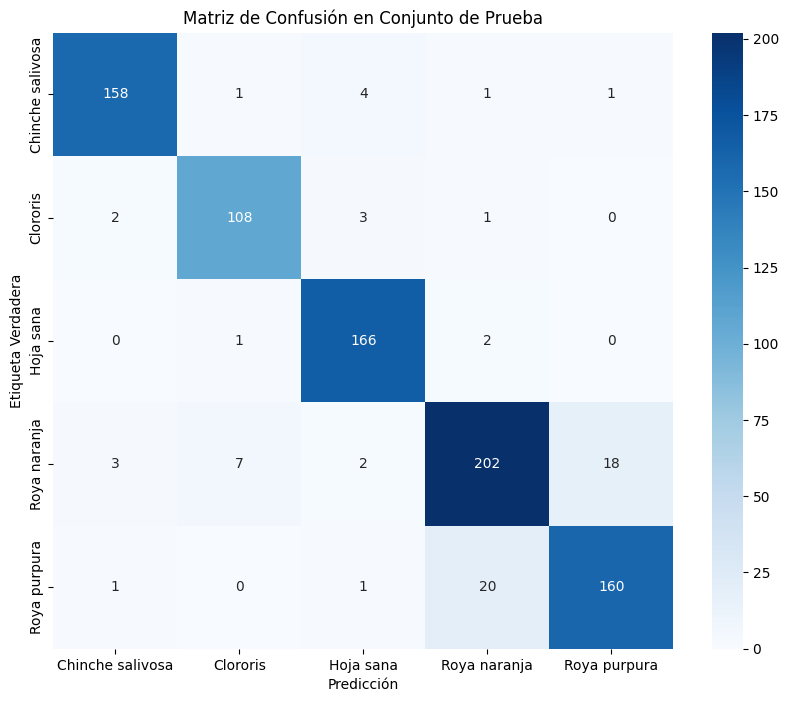

In [ ]:
# Visualizar la matriz de confusión en prueba
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_test, xticklabels=class_names, yticklabels=class_names, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicción')
plt.ylabel('Etiqueta Verdadera')
plt.title('Matriz de Confusión en Conjunto de Prueba')
plt.show()

In [ ]:
# Reporte de clasificación en prueba
print("Reporte de clasificación en Conjunto de Prueba:")
print(classification_report(y_test_true, y_test_pred, target_names=class_names))

Reporte de clasificación en Conjunto de Prueba:
                  precision    recall  f1-score   support

Chinche salivosa       0.96      0.96      0.96       165
        Clororis       0.92      0.95      0.94       114
       Hoja sana       0.94      0.98      0.96       169
    Roya naranja       0.89      0.87      0.88       232
    Roya purpura       0.89      0.88      0.89       182

        accuracy                           0.92       862
       macro avg       0.92      0.93      0.93       862
    weighted avg       0.92      0.92      0.92       862



In [ ]:
# Importar bibliotecas necesarias
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, auc
from sklearn.utils import class_weight
from sklearn.preprocessing import label_binarize

import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2, ResNet50, EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Concatenate, Input, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model

27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 267ms/step


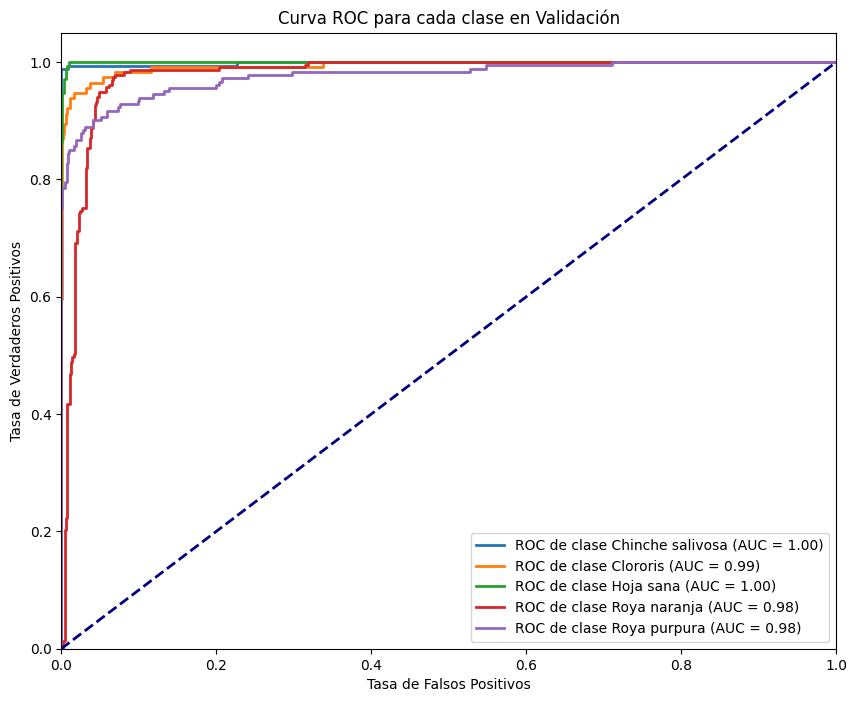

27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 274ms/step


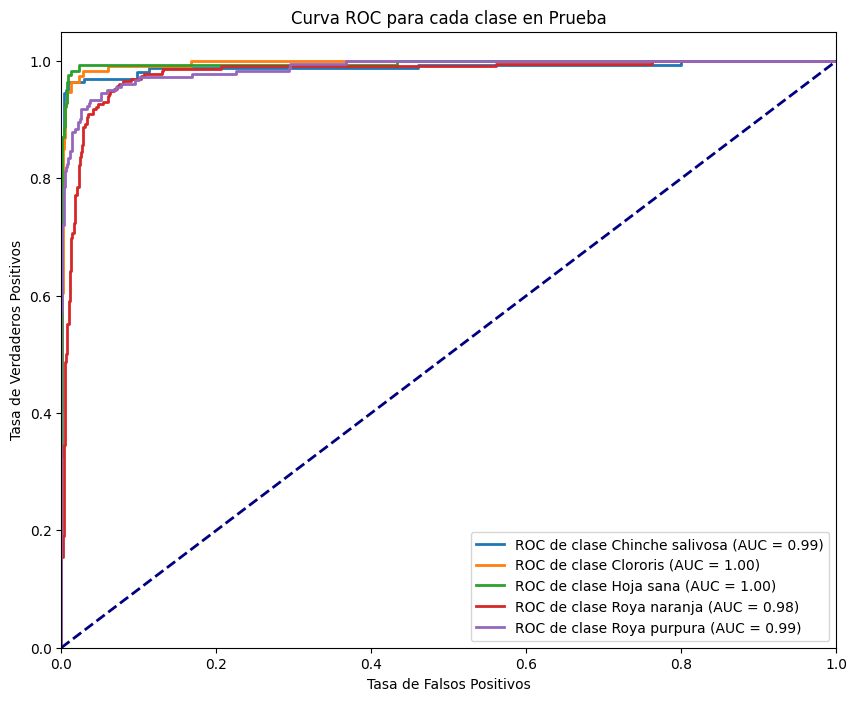

In [ ]:
# Gráfica de Curvas ROC para Validación y Prueba
def plot_roc_curves(ds, true_labels, dataset_name="Validación"):
    # Binarizar las etiquetas verdaderas
    y_binarized = label_binarize(true_labels, classes=list(range(len(class_names))))

    # Obtener probabilidades de predicción para cada clase
    y_pred_probs = ensemble_model_loaded.predict(ds)

    # Calcular la curva ROC y el AUC para cada clase
    fpr, tpr, roc_auc = {}, {}, {}
    for i in range(len(class_names)):
        fpr[i], tpr[i], _ = roc_curve(y_binarized[:, i], y_pred_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Graficar todas las curvas ROC
    plt.figure(figsize=(10, 8))
    for i in range(len(class_names)):
        plt.plot(fpr[i], tpr[i], lw=2, label=f'ROC de clase {class_names[i]} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Tasa de Falsos Positivos')
    plt.ylabel('Tasa de Verdaderos Positivos')
    plt.title(f'Curva ROC para cada clase en {dataset_name}')
    plt.legend(loc="lower right")
    plt.show()

# Obtener etiquetas verdaderas para validación y prueba
y_val_true = np.concatenate([y for _, y in val_ds], axis=0)
y_test_true = np.concatenate([y for _, y in test_ds], axis=0)

# Graficar la curva ROC para validación
plot_roc_curves(val_ds, y_val_true, dataset_name="Validación")

# Graficar la curva ROC para prueba
plot_roc_curves(test_ds, y_test_true, dataset_name="Prueba")




In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


In [ ]:
def make_saliency_map(model, img_tensor, label, class_names):
    """
    Genera un Saliency Map para una imagen y una clase específica.

    Args:
        model: Modelo entrenado de Keras.
        img_tensor: Tensor de la imagen de entrada.
        label: Etiqueta verdadera de la imagen.
        class_names: Lista de nombres de clases.

    Returns:
        Saliency Map de la imagen.
    """
    img_tensor = tf.cast(img_tensor, tf.float32)
    img_tensor = tf.expand_dims(img_tensor, axis=0)  # Añadir dimensión de batch

    with tf.GradientTape() as tape:
        tape.watch(img_tensor)
        predictions = model(img_tensor)
        loss = predictions[:, label]

    # Obtener los gradientes de la pérdida con respecto a la entrada
    gradients = tape.gradient(loss, img_tensor)

    # Tomar el valor absoluto máximo de los gradientes a través de los canales de color
    saliency = tf.reduce_max(tf.abs(gradients), axis=-1)[0]

    return saliency.numpy()


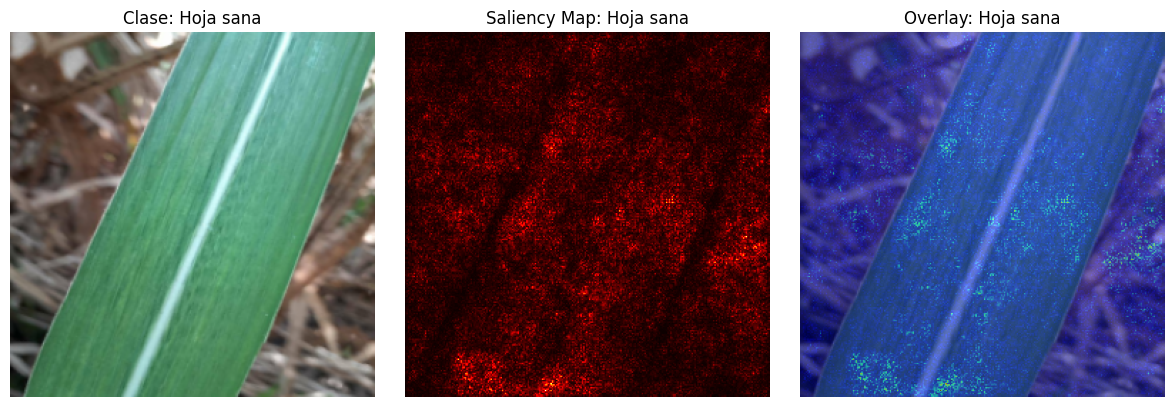

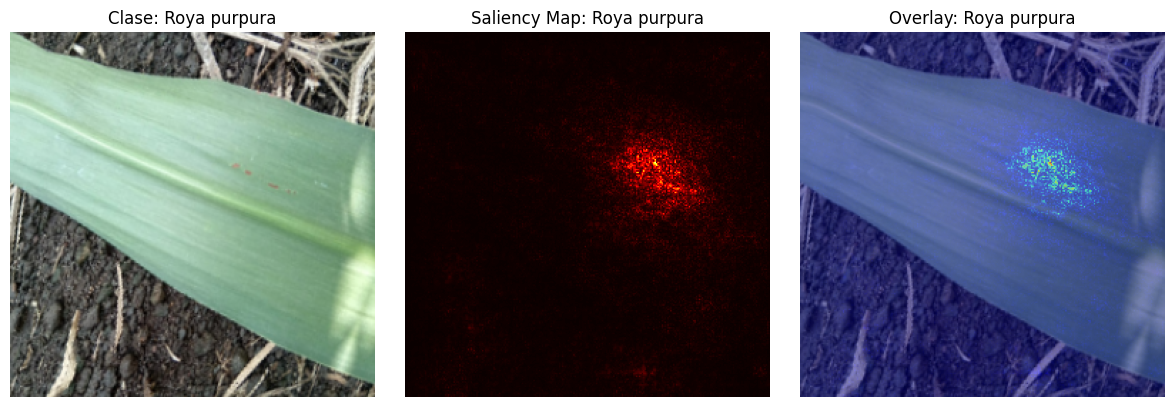

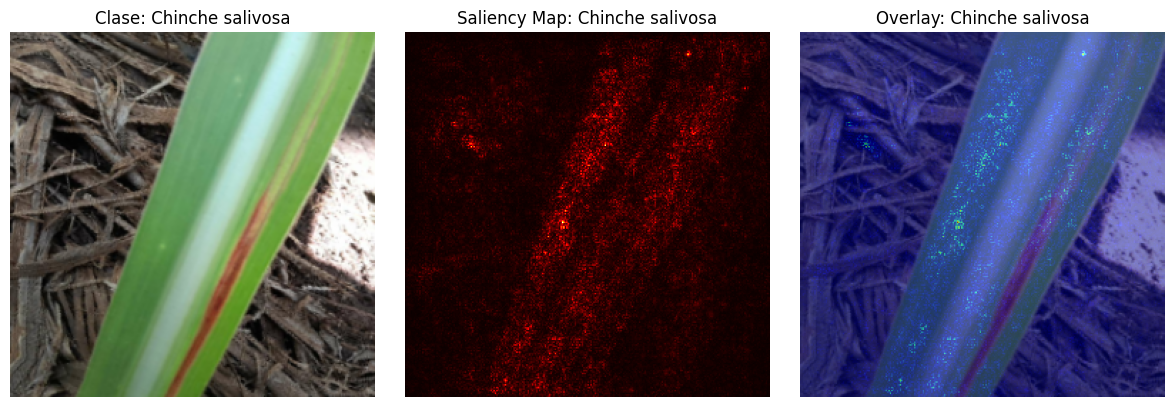

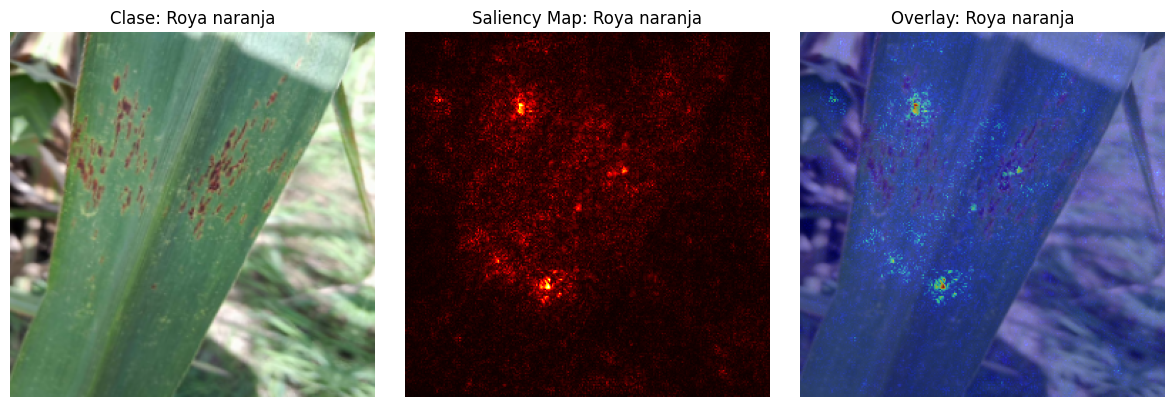

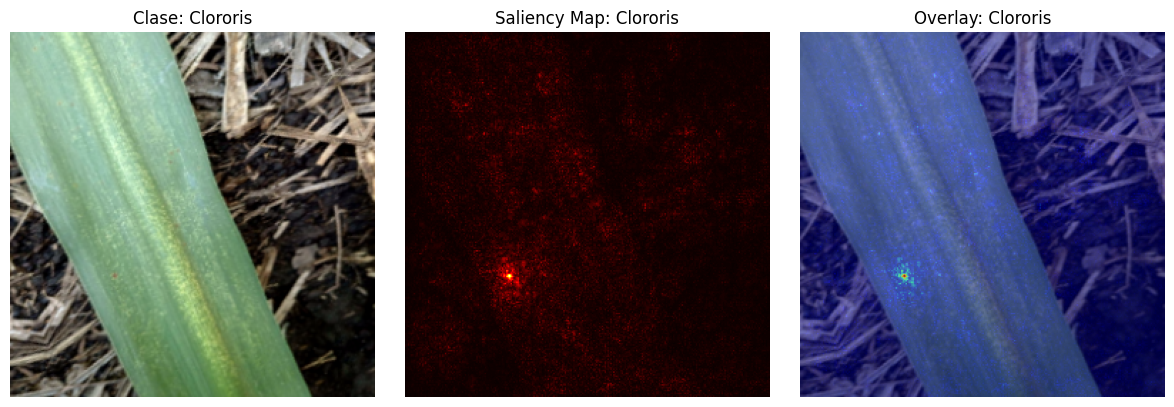

In [ ]:
# Seleccionar una imagen por clase del conjunto de validación
def get_sample_images(ds, num_classes):
    samples = {}
    for img, label in ds.unbatch().take(len(ds)*BATCH_SIZE):
        label = label.numpy()
        if label not in samples and label < num_classes:
            samples[label] = img.numpy()
        if len(samples) == num_classes:
            break
    return samples

# Obtener muestras
sample_images = get_sample_images(val_ds, len(class_names))

# Generar y visualizar Saliency Maps de forma individual
for idx, (label, img) in enumerate(sample_images.items()):
    saliency_map = make_saliency_map(ensemble_model_loaded, img, label, class_names)

    # Crear una nueva figura para cada imagen/clase
    plt.figure(figsize=(12, 4))

    # Normalizar la imagen para una visualización correcta
    img = (img - img.min()) / (img.max() - img.min())  # Normalizar para que la imagen se vea correctamente

    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title(f"Clase: {class_names[label]}")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(saliency_map, cmap='hot')
    plt.title(f"Saliency Map: {class_names[label]}")
    plt.axis('off')

    # Superponer el Saliency Map sobre la imagen original
    plt.subplot(1, 3, 3)
    plt.imshow(img)
    plt.imshow(saliency_map, cmap='jet', alpha=0.5)
    plt.title(f"Overlay: {class_names[label]}")
    plt.axis('off')

    plt.tight_layout()
    plt.show()